# DO NOT RUN THIS WITHOUT HAVING RAN SNAPS CORRECION FIRST


# Snaps analysis (2nd step)

## - Requirements:

### * This program runs on the output of the  "Correction" program (1 step) 
### * you must edit your experiment parameters in the "Modifiable User Parameters" box.
### * You also must edit the number of mothers and the threshold segmentation values in order to improve your results. Check it out in the following boxes.


## - Output:

### * Mother cell parameters  (length, area, fluorescence, etc.) ("MotherData.csv")
### * Same as the above but for every cell in the picture (not just the mother cells) ("AllCellData.csv")

## Libraries

In [1]:
%matplotlib inline
import cv2 #Image segmentation Library
import numpy as np #Numerical functions lib
from matplotlib import pyplot as plt #Basic ploting lib
import sys
import os #Lib for get the operative system sintaxis
from glob import glob #library used for get the file paths
import seaborn as sns #Library used for a nicer plotting
import pandas as pd
import random

#CUSTOM FUNCTIONS


# Quicksort algorithm implementation
def quicksort(l):
        if l:
                left = [x for x in l if x < l[0]]
                right = [x for x in l if x > l[0]]
                if len(left) > 1:
                        left = quicksort(left)
                if len(right) > 1:
                        right = quicksort(right)
                return left + [l[0]] * l.count(l[0]) + right

# Custom peak detection algorithm y = data, thresh = peak heigth, peakdist= mininimum distance between peaks
def indexes(y,thresh,peakdist): 
    dy = np.diff(y)
    ind = []
    for i in range(len(dy)):
        if len(ind) > 0:
            if dy[i] < dy[int(i-1)] and dy[i] <- thresh and i - peakdist > ind[-1]:
                ind.append(i)
        elif len(ind) == 0:
            if dy[i] < dy[int(i-1)] and dy[i] <- thresh:
                ind.append(i)
    return ind

## User modifiable  parameters:
##### please make sure you ran the cell after making any changes as merely changing them does not actually update any values

In [20]:
# pixel calibration 
camerapsize = 6.45
binning = 2
cMount = 0.7
objMag = 100
lensMag = 1

# Time parameters
# initialframe: (positive int) number of the image from which the user decides to start measuring.
# timebetweenframes: (positive int) time separation from one measurement to the next.
initialframe = 0 
timebetweenframes = 6

## Bellow this point, you only must edit the mother number and the segmentation threshold

## Program parameters 

In [3]:

initialtime=initialframe*timebetweenframes
pixelsize = camerapsize*binning/(cMount*objMag*lensMag)

red_dir = './correctedrfptif/' 
green_dir = './correctedgfptif/'
mask_dir = './jpegformask'  

deltax = 30 # the max horizontal drift you think affected your timelapse (pixels)
deltay = 80 # the max vertical drift you think affected your timelapse (pixels)

f = open('parameters.csv', "w")
f.close()
f = open('parameters.csv', "w")

f.write('initialframe,timebetweenframes,camerapsize,binning,cMount,objMag,lensMag,deltay,deltax \n')
f.write(str(initialframe)+ ',' + str(timebetweenframes) + ',' + str(camerapsize) + ',' + str(binning) +\
        ',' + str(cMount) + ',' + str(objMag) + ',' + str(lensMag) + ',' + str(deltay) + ',' + str(deltax) + '\n')
f.close()

# Main code

In [12]:
#reading all data you need
files_mask = [] 
pattern_mask   = "*.jpg"

files_red = [] 
pattern_red   = "*.tif"

files_green = [] 
pattern_green   = "*.tif"

for dir,_,_ in os.walk(mask_dir):
    files_mask.extend(glob(os.path.join(dir,pattern_mask)))

for dir,_,_ in os.walk(red_dir):
    files_red.extend(glob(os.path.join(dir,pattern_red)))
    
for dir,_,_ in os.walk(green_dir):
    files_green.extend(glob(os.path.join(dir,pattern_green)))
    
position_names =  [x[1] for x in os.walk(red_dir)][0]

files_mask.sort()
files_mask = np.array(files_mask).reshape(len(position_names),(int(len(files_mask)/len(position_names)))).tolist()

files_red.sort()
files_red = np.array(files_red).reshape(len(position_names),(int(len(files_red)/len(position_names)))).tolist()

files_green.sort()
files_green = np.array(files_green).reshape(len(position_names),(int(len(files_green)/len(position_names)))).tolist()

if len(files_green[0]) == 0:
    GFPimages = False
else: 
    GFPimages = True

print (str(len(position_names)) + ' positions were found')
print(str(len(files_mask[0])) + ' images for segmentation found per position')
print(str(len(files_red[0])) + ' RFP images found per position')
print(str(len(files_green[0])) + ' GFP images found per position')

7 positions were found
132 images for segmentation found per position
132 RFP images found per position
0 GFP images found per position


In [13]:
threshold = 220 #this number will be used for segmentation

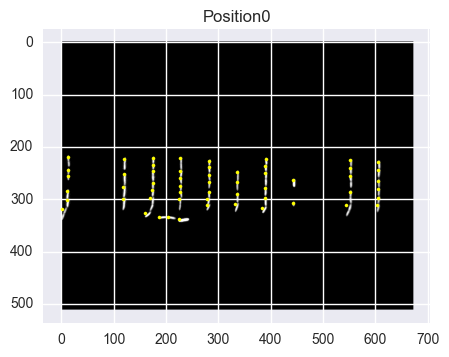

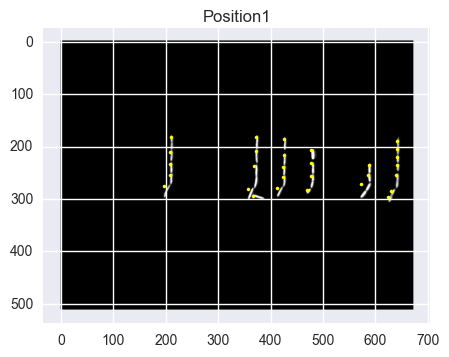

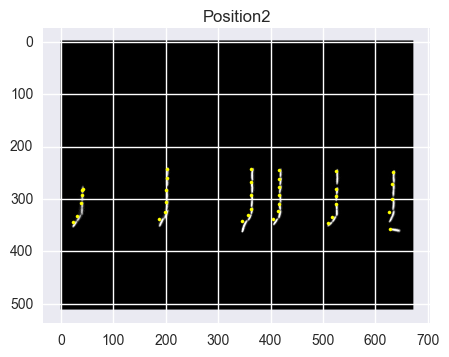

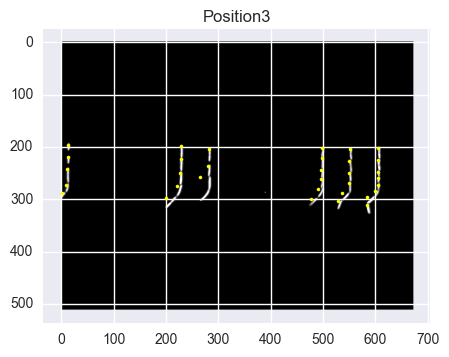

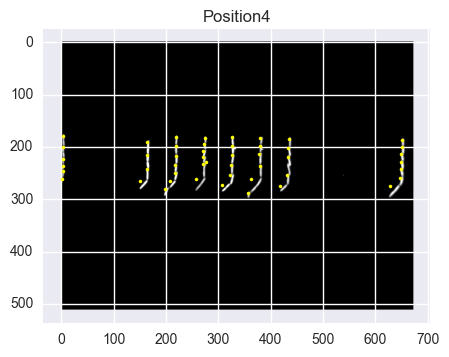

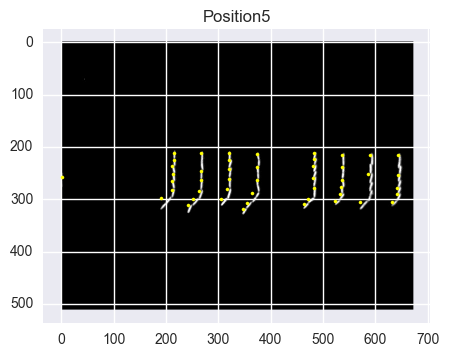

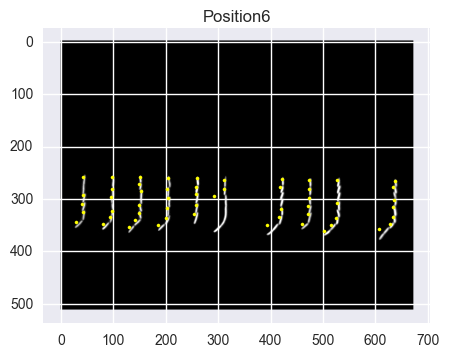

In [14]:
allcontours = []
allcoordinatesx = [] 
allcoordinatesy = []

for j in range(len(position_names)):
    coordinatesx = [] 
    coordinatesy = []
    
    first_image = files_mask[j][0]
    img = cv2.imread(first_image,1)
    Yref = len(img)
    kernel_sharpen_3 = np.array([[-1,-1,-1,-1,-1],#sharpening kernel
                                 [-1,2,2,2,-1],
                                 [-1,2,8,2,-1],
                                 [-1,2,2,2,-1],
                                 [-1,-1,-1,-1,-1]]) / 8.0
    
    equ = cv2.filter2D(img, -1, kernel_sharpen_3) #sharpening
    gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY) #converting into a gray scales
    ret, thresh = cv2.threshold(gray,threshold,255,cv2.THRESH_BINARY) #threshold definition
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) #contours
    allcontours.append(contours)
    for cnt in range(len(allcontours[j])):  
        x,y,w,h = cv2.boundingRect(allcontours[j][cnt])
        coordinatesx.append(x)
        coordinatesy.append(y)
    allcoordinatesx.append(coordinatesx)
    allcoordinatesy.append(coordinatesy)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_title("Position"+ str(j)) 
    ax.imshow(img)
    ax.scatter(allcoordinatesx[j],allcoordinatesy[j], s=5,color='yellow') 

# Please count the viable cells 
### Things to take into account:


##### - User must only count yellow dots
##### - User must keep in mind that the mother will always be on top of all other cells
##### - User must input one mother count, separated by commas, per position folder*


(ie. for 4 positions: 10,12,15,7 )

##### - In this box, you will see mothers as green coloured contours


In [15]:
mothers = 8,4,5,6,8,8,10 #in this example, seven positions

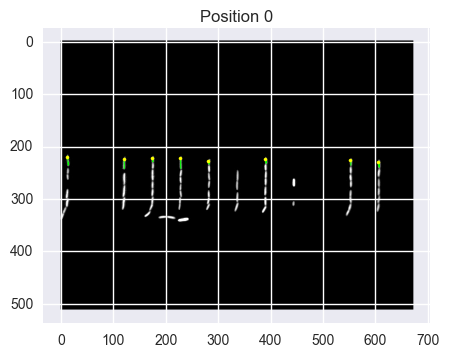

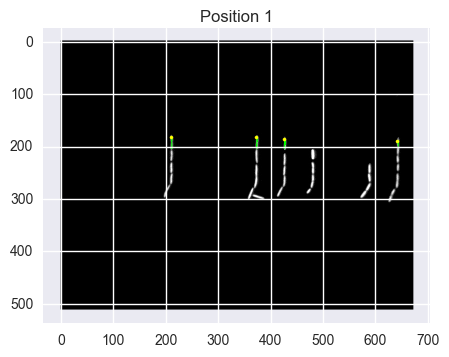

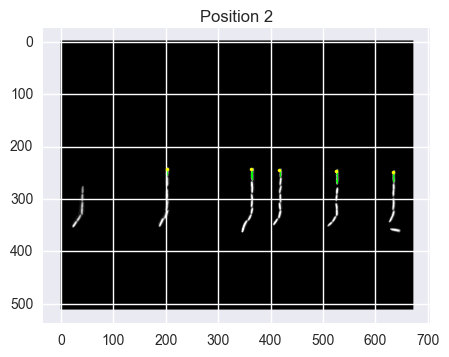

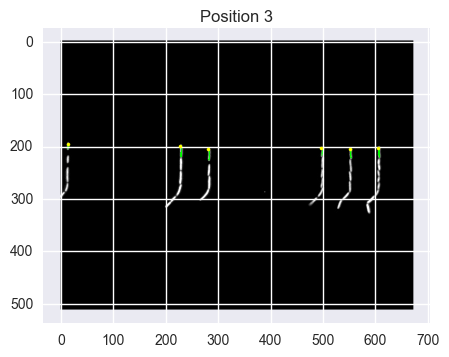

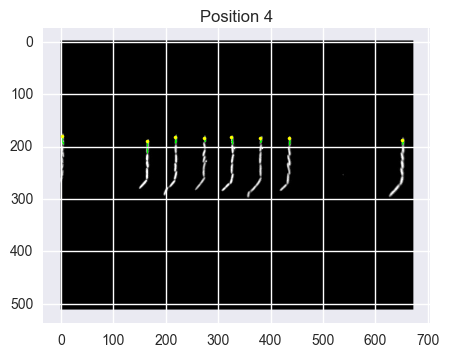

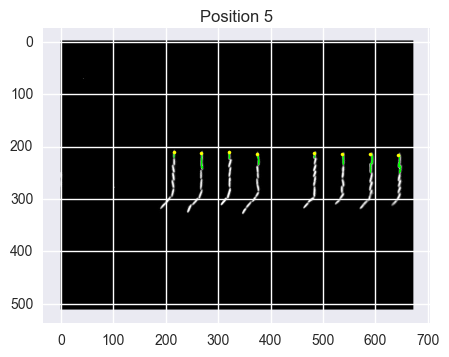

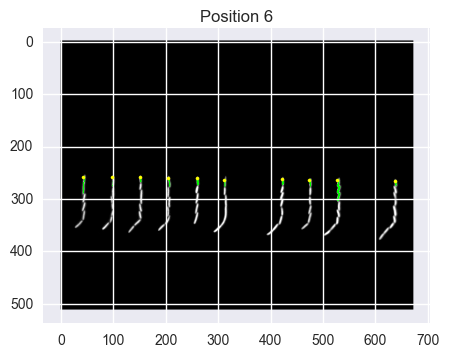

In [16]:
#sorting contours in order to select the mothers
mx = []#array of mother's coordinates in x
my = []#array of mother's coordinates in y
xrg = []#array of mother's range in x
yrg = []#array of mother's range in y
posm = []

for j in range(len(position_names)):   
    first_image = files_mask[j][0]
    img = cv2.imread(first_image,1)
    temp = []
    temp2 = []
    mxtmp = []
    mytmp = []
    posmtmp = []
    xrgtmp = []
    yrgtmp = []

    for i in range(len(allcoordinatesy[j])):
        temp.append([allcoordinatesy[j][i],allcoordinatesx[j][i],int(i)])
    temp = quicksort(temp)
    
    for i in range(mothers[j]):
        temp2.append([temp[i][1],temp[i][0],temp[i][2]])
    temp2 = quicksort(temp2)
    
    for i in range(mothers[j]):
        mxtmp.append(temp2[i][0])
        mytmp.append(temp2[i][1])
        xrgtmp.append(range(temp2[i][0]-deltax,temp2[i][0]+deltax))
        yrgtmp.append(range(temp2[i][1]-deltax,temp2[i][1]+deltax))
        posmtmp.append(temp2[i][2])
        
    xrg.append(xrgtmp)
    yrg.append(yrgtmp)
    mx.append(mxtmp)
    my.append(mytmp)
    posm.append(posmtmp)
        
    for i in range(len(mx[j])):
        coord = posm[j][i]
        cnt = allcontours[j][coord]
        cv2.drawContours(img, [cnt], 0, (0,255,0),-1) 
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_title("Position "+ str(j)) 
    ax.imshow(img)
    ax.scatter(mx[j],my[j], s=5,color='yellow')

In [17]:
#doing mother tracking and statistics over all positions and frames
FULLfeat = []
Allfeat = []
SISTERfeat = []
mx2 = list(mx)
my2 = list(my)
for k in range(len(position_names)):#k = positions
    allfeat = []
    Fullfeat = []
    Sisterfeat = []
    #array initialisation
##--  opening images    
    for i in range(0,len(files_red[k])): #i = frame
        fullfeat = []
        filepath_red = files_red[k][i]
        filepath_mask = files_mask[k][i]
    
        img = cv2.imread(filepath_mask, 1)#mask
        img3 = cv2.imread(filepath_red, 2 | 4)#rfp image
        if(GFPimages):
            filepath_green = files_green[k][i]
            img2 = cv2.imread(filepath_green, 2 | 4)#gfp image
            
##-- segmentation            
        equ = cv2.filter2D(img, -1, kernel_sharpen_3)#sharpening
        gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY)#to gray scale
        ret,thresh = cv2.threshold(gray,threshold,255,0)#computing threshold
        im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)#finding contours
        
        cont = np.zeros_like(mx[k])#mother array
        mxtemp = np.zeros_like(mx[k])#x coordinates        
        mytemp=[len(img)]*len(my[k]) #ycoordinates   
        feat = [0]*len(my[k])#mother fatures

        for cnt in range(len(contours)):#counting over contours
            listintR = []
            if(GFPimages):
                listintG = []
            aimg = np.zeros_like(img)#image of zeros
            cv2.drawContours(aimg, contours, cnt, (0,0,255), thickness= -1)#drawing contours
            pts = np.where(aimg != 0)#finding the pixels
            listintR.append(img3[pts[0], pts[1]])#array of pixels per contour
            r = 0
            r = np.mean(listintR[0])#computing RFP fluorescense (average value of pixels)
            intR=r
            
            if(GFPimages):
                pts = np.where(aimg != 0)
                listintG.append(img2[pts[0], pts[1]])                
                G = 0
                G = np.mean(listintG[0])#computing GFP fluorescense (average value of pixels)
                intG=G
                
            x,y,w,h = cv2.boundingRect(contours[cnt])
            area = cv2.contourArea(contours[cnt])
            length=h * pixelsize
            wid=w * pixelsize
            asp=w / h
            are=area * pixelsize ** 2
            if(length>0.5 and length<10):
                if(GFPimages):
                    #storing the features of each cell
                    fullfeat.append([length, are, wid, asp, intR, intG])
                else:
                    fullfeat.append([length, are, wid, asp, intR])
#testing mothers          
            for j in range(len(my[k])):#counting im mothers
                #k=position folder, j=mother
                if (x in xrg[k][j] and y in yrg[k][j] and y < mytemp[j]):
                    #if the cell fits in the box defined in previous frame then is mother
                    mytemp[j] = y #we store the coordinates
                    mxtemp[j] = x
                    if(GFPimages):
                        feat[j] = [intR,length,wid,asp, are,intG]
                    else:
                        feat[j] = [intR,length,wid,asp,are]#stroing all feature         
#refreshing mother's box coordinates
        mx[k] = mxtemp
        my[k] = mytemp

        for l in range(len(xrg[k])):
            xrg[k][l]=range(mxtemp[l]-deltax,mxtemp[l]+deltax)#refreshing mother's box
            yrg[k][l]=range(mytemp[l]-deltay,mytemp[l]+deltay)
        Fullfeat.append(fullfeat)
        allfeat.append(feat)#countin over frames
        
#looking for the sister

        distance = [len(img)]*len(my[k])
        sisterfeat = [0]*len(my[k])#mother fatures
        for cnt in range(len(contours)):                      
            x,y,w,h = cv2.boundingRect(contours[cnt])
                      
            for j in range(len(my[k])):
                if (x in xrg[k][j] and y != my[k][j] and abs(y-my[k][j]) < distance[j]):
                    
                    my2[k][j] = y
                    mx2[k][j] = x
                    distance[j]=abs(y-my[k][j])
                    area = cv2.contourArea(contours[cnt])
                    length=h * pixelsize
                    wid=w * pixelsize
                    asp=w / h
                    are=area * pixelsize ** 2  
                    
                    listintR = []
                    aimg = np.zeros_like(img)#image of zeros
                    cv2.drawContours(aimg, contours, cnt, (0,0,255), thickness= -1)#drwing contours
                    pts = np.where(aimg != 0)#finding the pixels
                    listintR.append(img3[pts[0], pts[1]])#array of pixel of contour
                    r = 0
                    r = np.mean(listintR[0])#computing RFP fluorescense (average value of pixels)
                    intR=r
            
                    if(GFPimages):
                        listintG = []  
                        pts = np.where(aimg != 0)
                        listintG.append(img2[pts[0], pts[1]])                
                        G = 0
                        G = np.mean(listintG[0])#computing GFP fluorescense (average value of pixels)
                        intG=G
                    if(GFPimages):
                        sisterfeat[j] = [intR,length,wid,asp, are,intG]
                    else:
                        sisterfeat[j] = [intR,length,wid,asp,are]#stroing all features
            for j in range(len(sisterfeat)):                
                if (sisterfeat[j]!= 0 and allfeat[i][j] != 0):
                    if((allfeat[i][j][0]/sisterfeat[j][0]> 1.3) or (allfeat[i][j][0]/sisterfeat[j][0]< 0.77)):
                        sisterfeat[j] = 0
                        allfeat[i][j] = 0
                        
        Sisterfeat.append(sisterfeat)
#----------if you whant to see how is segmentation, uncoment the following lines
        #if (i%15==0):            
            #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            #x.set_title("Position "+ str(k)+ " frame "+ str(i)) 
            #x.imshow(img)
            #ax.scatter(allfeat[0][i][0],Sisterfeat[0][i][0], s=5,color='yellow')
            #ax.scatter(mx2[k],my2[k], s=5,color='purple')
           
    Allfeat.append(allfeat) #counting over positions
    FULLfeat.append(Fullfeat)
    SISTERfeat.append(Sisterfeat)
    print("pos "+str(k)+" done\n")

pos 0 done

pos 1 done

pos 2 done

pos 3 done

pos 4 done

pos 5 done

pos 6 done



# Data, Finally

### Mothers first

In [21]:
f = open('MotherData.csv', 'w')
f.close()
f = open('MotherData.csv', 'w')
if (GFPimages):
    f.write('Frame,Mother,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,MeanGFP,\
    SLength(um),SArea(um**2),SWidth(um),SL/W,SMeanRFP,SMeanGFP\n')
    cell = 0
    for k in range(len(Allfeat)): #pos
        for j in range(len(Allfeat[k])): #frame
            for i in range(len(Allfeat[k][j])): #cell                
                if Allfeat[k][j][i] != 0 and SISTERfeat[k][j][i] != 0:
                    f.write(str(j + initialframe) + ',' + str(cell+i) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(Allfeat[k][j][i][1]) + ',' + str(Allfeat[k][j][i][4]) + ',' + str(Allfeat[k][j][i][2]) \
                        + ',' + str(Allfeat[k][j][i][3]) + ',' + str(Allfeat[k][j][i][0]) + ',' + str(Allfeat[k][j][i][5])\
                        +',' + str(SISTERfeat[k][j][i][1]) + ',' + str(SISTERfeat[k][j][i][4]) + ',' + str(SISTERfeat[k][j][i][2]) \
                        + ',' + str(SISTERfeat[k][j][i][3]) + ',' + str(SISTERfeat[k][j][i][0]) + ',' + str(SISTERfeat[k][j][i][5])+'\n')
        cell+=len(Allfeat[k][0])
            
else:
    f.write('Frame,Mother,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,\
    SLength(um),SArea(um**2),SWidth(um),SL/W,SMeanRFP\n')
    cell = 0
    for k in range(len(Allfeat)): #pos
        for j in range(len(Allfeat[k])): #frame
            for i in range(len(Allfeat[k][j])): #cell                
                if Allfeat[k][j][i] != 0 and SISTERfeat[k][j][i] != 0:
                    f.write(str(j + initialframe) + ',' + str(cell+i) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(Allfeat[k][j][i][1]) + ',' + str(Allfeat[k][j][i][4]) + ',' + str(Allfeat[k][j][i][2]) \
                        + ',' + str(Allfeat[k][j][i][3]) + ',' + str(Allfeat[k][j][i][0]) \
                        +',' + str(SISTERfeat[k][j][i][1]) + ',' + str(SISTERfeat[k][j][i][4]) + ',' + str(SISTERfeat[k][j][i][2]) \
                        + ',' + str(SISTERfeat[k][j][i][3]) + ',' + str(SISTERfeat[k][j][i][0]) +'\n')
        cell+=len(Allfeat[k][0])
f.close()

### Now all cells

In [22]:
f = open('AllCellData.csv', 'w')
f.close()
f = open('AllCellData.csv', 'w')

if (GFPimages):
    f.write('Position,Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,MeanGFP\n')
    for k in range(len(FULLfeat)): #pos
        for j in range(len(FULLfeat[k])): #frame
            for i in range(len(FULLfeat[k][j])): #cell
                f.write(str(k) + ',' + str(j + initialframe) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(FULLfeat[k][j][i][0]) + ',' + str(FULLfeat[k][j][i][1]) + ',' + str(FULLfeat[k][j][i][2]) \
                        + ',' + str(FULLfeat[k][j][i][3]) + ',' + str(FULLfeat[k][j][i][4]) + ',' + str(FULLfeat[k][j][i][5])+'\n')
else:
    f.write('Position,Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP\n')
    for k in range(len(FULLfeat)): #pos
        for j in range(len(FULLfeat[k])): #frame
            for i in range(len(FULLfeat[k][j])): #cell
                f.write(str(k) + ',' + str(j + initialframe) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(FULLfeat[k][j][i][0]) + ',' + str(FULLfeat[k][j][i][1]) + ',' + str(FULLfeat[k][j][i][2]) \
                        + ',' + str(FULLfeat[k][j][i][3]) + ',' + str(FULLfeat[k][j][i][4]) +'\n')
f.close()